### Import Library

In [ ]:
# Install library
!pip install yfinance
!pip install yfinance pandas lxml requests
!pip install keras-tuner --quiet
import yfinance as yf
import pandas as pd
import requests
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras_tuner as kt
import matplotlib.pyplot as plt

### Data Ingestion: Getting 200+ SNP500 Companies Data

In this step, i have initiative to forecast around 200+ companies in SNP500. There is two step first to get the data:
1. List All the companies
2. Check and validate that the companies is available at yahoo finance

In [ ]:
# 1. List All SNP500 Companies
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

sp500_table = pd.read_html(response.text)
sp500 = sp500_table[0]

# Cleaning Symbol for configuration to yahoo finance
tickers = [t.replace(".", "-") for t in sp500["Symbol"].to_list()]

print("Total tickers from Wikipedia:", len(tickers))

#### Checking Available at Yahoo Finance

In [ ]:
# 2. Checking is all companies data from SNP500 is available at Yahoo finance
available_tickers = []

for t in tickers:
    try:
        df = yf.download(t, start="2022-01-01", end="2025-01-01", progress=False)
        if not df.empty:
            available_tickers.append(t)
    except:
        pass

print("Ticker available at Yahoo Finance in SNP500:", len(available_tickers))

### Mount at Google Drive

I save the data at My Drive, this is for storage unit according to what was said at the Paper

In [8]:
#Save ALL Dataset from SNP500 Companies in 2022-2025 in Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = "/content/drive/MyDrive/SNP500"
os.makedirs(save_path, exist_ok=True)

for t in available_tickers:
    print(f"Downloading {t} ...")
    df = yf.download(t, start="2022-01-01", end="2025-01-01", progress=False)
    file_path = os.path.join(save_path, f"{t}.csv")
    df.to_csv(file_path)

#### Cleaning & Prepare Data

This step is cleaning and prepare data such as:
1. Drop The NULL data (first 2 rows)
2. Delete useless row
3. Convert the historical data into numerical

In [ ]:
def clean_and_prepare(file_path):
    # Load raw CSV
    df = pd.read_csv(file_path)

    # Drop the first two rows
    df = df.drop([0, 1]).reset_index(drop=True)

    # Parse Date (it's in "Price" column)
    df["Price"] = pd.to_datetime(df["Price"])
    df = df.rename(columns={"Price": "Date"})
    df = df.set_index("Date")

    # Convert numeric columns
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

# Loop through all files and overwrite clean version
for file in os.listdir(save_path):
    if file.endswith(".csv"):
        file_path = os.path.join(save_path, file)
        print(f"Cleaning {file} ...")

        df_clean = clean_and_prepare(file_path)

        # overwrite clean csv
        df_clean.to_csv(file_path)

### Feature Engineering

#### Feature Engineering Seasonal Data & Technical Indicator

In this step, i was doing feature engineering to get seasonal data & technical indicator data. In seasonal data, this is feature that i create from financial historical data:
1. Day of Week
2. Day of Month
3. Month
4. Quarter

For the technical indicator i create:
1. AO: Awesome Oscillator
2. RSI: Relative Strength Index
3. ATR: Average True Range
4. ADX: Average Directional Movement Index
5. AI: Aroon Indicator
6. DR: Daily Return

After all the Technical indicator is computed, ALL HISTORICAL DATA IS REMOVED as what the writer say in the paper.

Notes: Due to limited access, i don't feature engineering for news data in this implementation


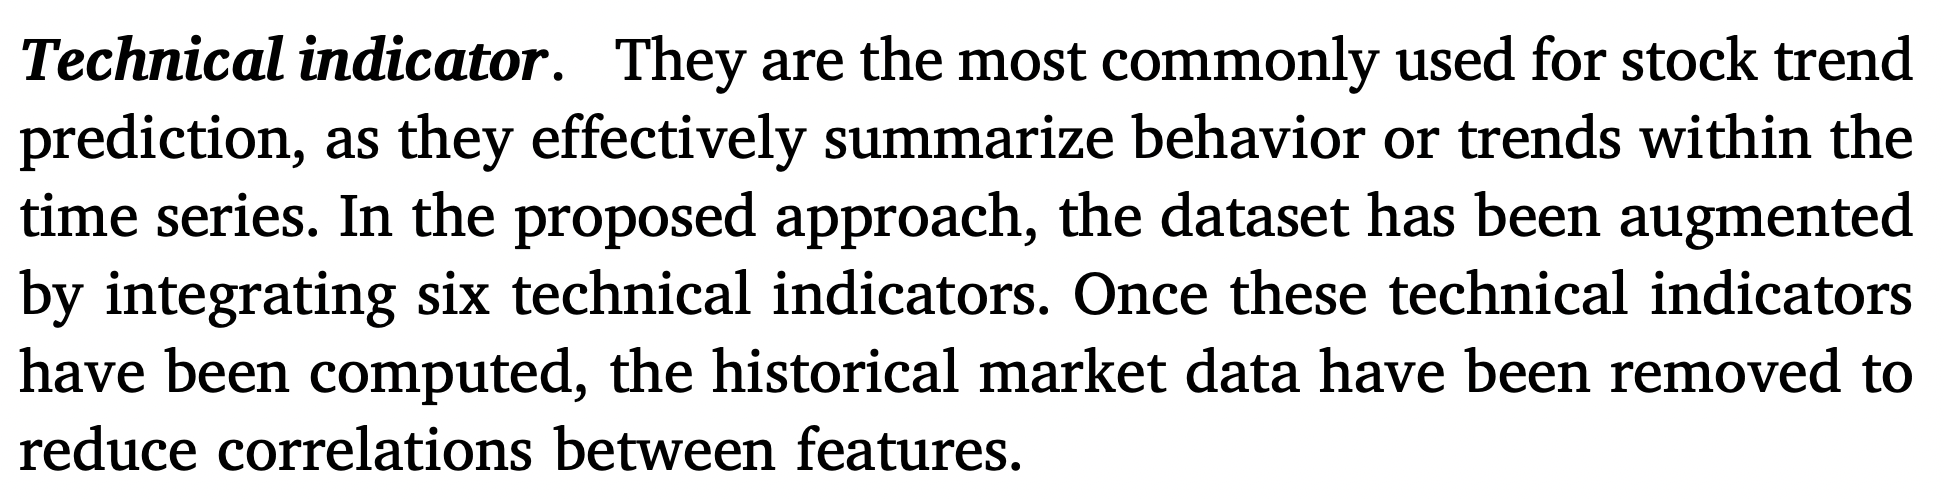

In [ ]:
def add_features(df,
                 rsi_period=14,#(Wilder, 1978)
                 atr_period=14,#(Wilder, 1978)
                 adx_period=14,#(Wilder, 1978)
                 aroon_period=25,#(Chande, 2001)
                 ao_short=5,#(Williams, 1998)
                 ao_long=34,#(Williams, 1998)
                 rolling_min_periods=None):

    df = df.copy()

    # Make datetime index clear
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"])
            df = df.set_index("Date")
        else:
            df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    # Make column used clear
    for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Choose min_periods for rolling (default = period)
    def mp(period):
        return rolling_min_periods if rolling_min_periods is not None else period

    # Seasonal Data
    df["DayOfWeek"]  = df.index.dayofweek
    df["DayOfMonth"] = df.index.day
    df["Month"]      = df.index.month
    df["Quarter"]    = df.index.quarter

    # AO: Awesome Oscillator
    median_price = (df["High"] + df["Low"]) / 2
    sma_short = median_price.rolling(window=ao_short, min_periods=mp(ao_short)).mean()
    sma_long  = median_price.rolling(window=ao_long,  min_periods=mp(ao_long)).mean()
    df["AO"] = sma_short - sma_long

    # RSI (Wilder smoothing via EWM alpha=1/n, adjust=False)
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)

    # Wilder 1978
    avg_gain = gain.ewm(alpha=1.0/rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1.0/rsi_period, adjust=False).mean()

    # avoid division by zero
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df["RSI"] = 100 - (100 / (1 + rs))
    df["RSI"] = df["RSI"].fillna(0)
    df.loc[(avg_gain==0) & (avg_loss==0), "RSI"] = 50
    df.loc[(avg_loss==0) & (avg_gain>0), "RSI"] = 100
    df.loc[(avg_gain==0) & (avg_loss>0), "RSI"] = 0

    # ATR (True Range then rolling mean)
    high_low = df["High"] - df["Low"]
    high_close = (df["High"] - df["Close"].shift()).abs()
    low_close  = (df["Low"]  - df["Close"].shift()).abs()

    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    # Wilder's ATR (EMA with alpha=1/n)
    df["ATR"] = tr.ewm(alpha=1/atr_period, adjust=False).mean()

    # ADX
    # Up/Down move
    up_move = df["High"].diff()
    down_move = df["Low"].shift() - df["Low"]

    plus_dm  = up_move.where((up_move > down_move) & (up_move > 0), 0.0)
    minus_dm = down_move.where((down_move > up_move) & (down_move > 0), 0.0)

    # Wilder’s smoothing (EMA with alpha=1/n)
    atr_smoothed      = tr.ewm(alpha=1/adx_period, adjust=False).mean()
    plus_dm_smoothed  = plus_dm.ewm(alpha=1/adx_period, adjust=False).mean()
    minus_dm_smoothed = minus_dm.ewm(alpha=1/adx_period, adjust=False).mean()

    # Directional Indicators
    plus_di  = 100 * (plus_dm_smoothed / atr_smoothed)
    minus_di = 100 * (minus_dm_smoothed / atr_smoothed)

    # DX and ADX
    dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan) ) * 100
    adx = dx.ewm(alpha=1/adx_period, adjust=False).mean()

    df["ADX"] = adx

    # Aroon Indicator (AI)
    def aroon_up(series, n):
        return series.rolling(window=n, min_periods=mp(n)).apply(
            lambda x: (n - (n - 1 - np.argmax(x))) / n * 100, raw=True
        )

    def aroon_down(series, n):
        return series.rolling(window=n, min_periods=mp(n)).apply(
            lambda x: (n - (n - 1 - np.argmin(x))) / n * 100, raw=True
        )

    a_up = aroon_up(df["High"], aroon_period)
    a_dn = aroon_down(df["Low"], aroon_period)
    df["AI"] = a_up - a_dn

    # Daily Return
    df["DR"] = 100.0 * (df["Close"] - df["Open"]) / df["Open"]

    return df

In [ ]:
for file in os.listdir(save_path):
    if file.endswith(".csv"):
        file_path = os.path.join(save_path, file)
        df = pd.read_csv(file_path, index_col="Date", parse_dates=True)

        df_feat = add_features(df)

        # save to a new folder so raw/clean data not overwritten
        out_path = "/content/drive/MyDrive/SNP500_features"
        os.makedirs(out_path, exist_ok=True)
        df_feat.to_csv(os.path.join(out_path, file))

#### One-hot encoding seasonal data

The Seasonal Data is aslo processed by using one-hot encoding

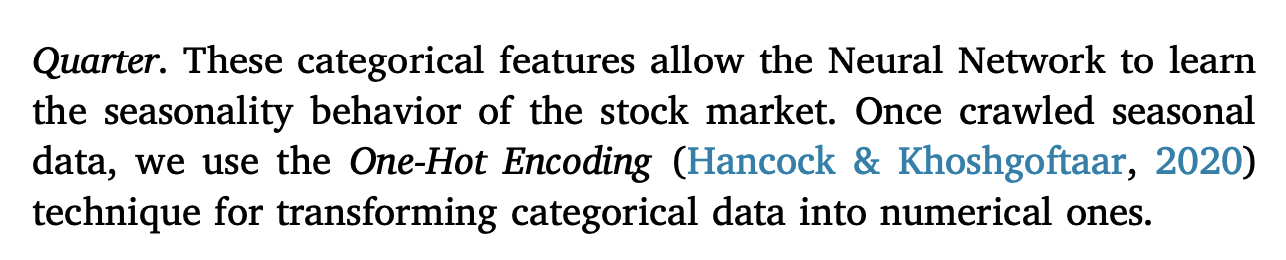

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Paths
features_path = "/content/drive/MyDrive/SNP500_features"
clean_path = "/content/drive/MyDrive/SNP500_clean"
os.makedirs(clean_path, exist_ok=True)

# Seasonal columns
seasonal_cols = ["DayOfWeek", "DayOfMonth", "Month", "Quarter"]

# OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop=None)

# Loop through all csv files in the features folder
for file in os.listdir(features_path):
    if file.endswith(".csv"):
        file_path = os.path.join(features_path, file)

        # Load dataset
        df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

        # Apply OHE only if seasonal cols exist
        if all(col in df.columns for col in seasonal_cols):
            encoded = encoder.fit_transform(df[seasonal_cols])
            encoded_cols = encoder.get_feature_names_out(seasonal_cols)
            encoded_df = pd.DataFrame(encoded, index=df.index, columns=encoded_cols)

            # Merge back
            df_encoded = pd.concat([df.drop(columns=seasonal_cols), encoded_df], axis=1)
        else:
            df_encoded = df  # fallback if seasonal cols missing

        # Save into SNP500_clean
        output_file = os.path.join(clean_path, file)
        df_encoded.to_csv(output_file)

#### Drop Financial Data (Based on Paper)

In [ ]:
clean_path = "/content/drive/MyDrive/SNP500_clean"

# Columns to remove
drop_cols = ["Close", "High", "Low", "Open", "Volume"]

for file in os.listdir(clean_path):
    if file.endswith(".csv"):
        file_path = os.path.join(clean_path, file)

        # Load dataset
        df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

        # Drop first 34 rows
        df = df.iloc[34:].copy()

        # Drop unnecessary columns (if they exist)
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

        # Save back (overwrite)
        df.to_csv(file_path)

#### Set Data Target & Feature

In [ ]:
clean_path = "/content/drive/MyDrive/SNP500_clean"

# Collect all files into one dataset dictionary
dataset = {}

# Loop through all CSV files in the folder
for file in os.listdir(clean_path):
    if file.endswith(".csv"):
        file_path = os.path.join(clean_path, file)

        # Load CSV
        df = pd.read_csv(file_path)

        # Ensure "DR" exists as target column
        if "DR" not in df.columns:
            raise ValueError(f"Column 'DR' not found in {file}")

        # Store dataframe in dict, key = filename
        dataset[file.replace(".csv", "")] = {
            "data": df.drop(columns=["DR"]),   # Features
            "target": df["DR"]                 # Prediction Column
        }

print(f"Loaded {len(dataset)} datasets with 'DR' as target.")

Loaded 503 datasets with 'DR' as target.


In [ ]:
dataset["AAPL"]["data"]

,Date,AO,RSI,ATR,ADX,AI,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,2022-02-22,-1.038285,35.147073,4.277948,32.326427,48.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2022-02-23,-2.221184,30.802114,4.421135,32.834229,48.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2022-02-24,-4.452469,36.143026,4.866120,34.283714,-40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2022-02-25,-5.569000,40.079042,4.816542,34.901639,-40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2022-02-28,-6.197013,40.583638,4.682156,35.379624,-40.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,2024-12-24,14.524893,75.750275,4.032742,43.476198,88.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
715,2024-12-26,15.050473,76.452852,3.920494,44.908711,92.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
716,2024-12-27,15.436582,67.626241,4.064666,44.213516,92.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
717,2024-12-30,15.070646,60.225589,4.118823,42.735235,88.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
dataset["AAPL"]["target"]

,DR
0,-0.400041
1,-3.304329
2,6.658804
3,0.616461
4,1.263337
...,...
714,1.060709
715,0.321463
716,-0.868786
717,-0.011893


### Data Splitting

At this process, data divided by 2 based on their units.
1. in Forecasting unit, which used LSTM Architecture is in time range: 2022-02-22 until 2024-10-31. In this step i split the data based on train, validation, and test for finding the best performance purposes.
2. In Advice unit, which use 2024-11-01 until 2024-12-31. I use this timeframe for test set in advice unit. In this range, the puspose is to get best 5 stocks selection with heuristic stock selection after forecasting 200+ stocks in SNP500.

In [9]:
DATA_PATH = "/content/drive/MyDrive/Muhammad Alvero/DS/SNP500_clean"

# Function for splitting data
def split_stock_data(file_path):
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df.sort_values("Date", inplace=True)

    # Filtering time range
    forecast_df = df[(df["Date"] >= "2022-02-22") & (df["Date"] <= "2024-10-31")]
    advice_df = df[(df["Date"] >= "2024-11-01") & (df["Date"] <= "2024-12-31")]

    # Split forecasting data (70:20:10)
    n = len(forecast_df)
    train_end = int(0.7 * n)
    val_end = int(0.9 * n)

    train_df = forecast_df.iloc[:train_end]
    val_df = forecast_df.iloc[train_end:val_end]
    test_df = forecast_df.iloc[val_end:]

    return train_df, val_df, test_df, advice_df

# Splitting all data
all_splits = {}

for fname in os.listdir(DATA_PATH):
    if fname.endswith(".csv"):
        file_path = os.path.join(DATA_PATH, fname)
        train, val, test, advice = split_stock_data(file_path)

        all_splits[fname] = {
            "train": train,
            "val": val,
            "test": test,
            "advice": advice
        }

print("Splitting selesai.")

Splitting selesai.


### Build Model LSTM

This step i build the LSTM Model based on the paper. (The function activation is also based on the paper)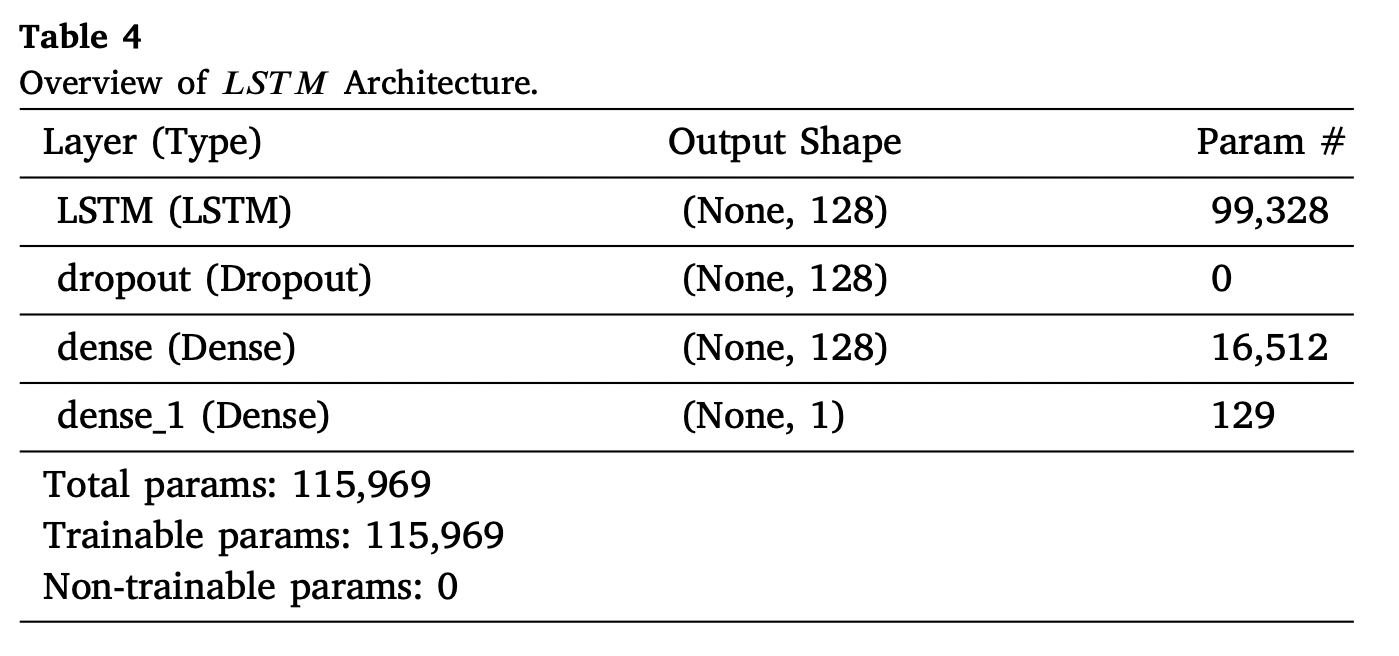

In [10]:
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation="tanh"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dense(1, activation="linear")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mse",
        metrics=["mae", "mse"]
    )
    return model

# Input Shape
input_shape = (60, 65)
model = build_lstm_model(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        99,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,969 (453.00 KB)

 Trainable params: 115,969 (453.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Choosing The Best Time Window Effectiveness in LSTM Model (2-8) Days

On this step. I have several assumption about the effectivness feature used and time window used in LSTM Model.
1. I assume Feature like using Seasonal Data is give more better performance than No Seasonal Data.
2. I assume Feature for Technical Indicator is give more better performance than Financial Historical Data.
3. I assume Daily Return give more better performance as target feature that closing price.
4. For time window, I modelling the best time window for effectiveness in LSTM Model. Because my data is different than in the paper (2-8) Days.

Notes: Due to limited access, i don't feature engineering for news data in this implementation

In [5]:
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def evaluate_time_window(train_df, val_df, time_window):
    # Fitur = All column except Date & DR
    X_train_full = train_df.drop(columns=["Date", "DR"]).values
    y_train_full = train_df["DR"].values

    X_val_full = val_df.drop(columns=["Date", "DR"]).values
    y_val_full = val_df["DR"].values

    # Create Sequence
    X_train, y_train = create_sequences(X_train_full, y_train_full, time_steps=time_window)
    X_val, y_val     = create_sequences(X_val_full,   y_val_full,   time_steps=time_window)

    if len(X_train) == 0 or len(X_val) == 0:
        return None

    # Model
    model = build_lstm_model((time_window, X_train.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Prediction
    y_pred = model.predict(X_val, verbose=0)

    # Calculate Metric
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    return mae, mse, rmse

# Find Best Time Window
sample_files = random.sample(list(all_splits.keys()), 40)
results = {w: [] for w in range(2, 9)}  # window 2–8

for fname in sample_files:
    train_df = all_splits[fname]["train"]
    val_df   = all_splits[fname]["val"]

    for w in range(2, 9):
        try:
            result = evaluate_time_window(train_df, val_df, w)
            if result:
                results[w].append(result)
        except Exception as e:
            print(f"Error {fname} window {w}: {e}")

# Summary Results
summary = {}
for w in results:
    if results[w]:
        maes  = [r[0] for r in results[w]]
        mses = [r[1] for r in results[w]]
        rmses = [r[2] for r in results[w]]
        summary[w] = {
            "MAE": np.mean(maes),
            "MSE": np.mean(mses),
            "RMSE": np.mean(rmses)
        }

print("Hasil rata-rata per time window:")
for w, metrics in summary.items():
    print(f"Window {w}: MAE={metrics['MAE']:.4f}, "
          f"MSE={metrics['MSE']:.2f}%, RMSE={metrics['RMSE']:.4f}")


Hasil rata-rata per time window:
Window 2: MAE=1.0570, MSE=2.14%, RMSE=1.4017
Window 3: MAE=1.0688, MSE=2.16%, RMSE=1.4122
Window 4: MAE=1.0687, MSE=2.17%, RMSE=1.4133
Window 5: MAE=1.0677, MSE=2.15%, RMSE=1.4090
Window 6: MAE=1.0759, MSE=2.19%, RMSE=1.4233
Window 7: MAE=1.0815, MSE=2.22%, RMSE=1.4270
Window 8: MAE=1.0767, MSE=2.20%, RMSE=1.4248


The best time window is 2

### HyperparameterTuning All Model

Hyperparametertuning with Bayesian Optimization to get the best parameter in every model.

In [ ]:
# Get Best Time Window = 2
def create_sequences(X, y, time_steps=2):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Model for Hyperparameter
def build_model(hp, input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(
            units=hp.Int("units", min_value=64, max_value=256, step=64),
            activation="tanh"
        ),
        tf.keras.layers.Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)),
        tf.keras.layers.Dense(
            units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
            activation="relu"
        ),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])
        ),
        loss="mse",
        metrics=["mae", "mse"]
    )
    return model

# Save Model
SAVE_DIR = "/content/drive/MyDrive/Muhammad Alvero/DS/Model"
os.makedirs(SAVE_DIR, exist_ok=True)

# Loop every dataset
for fname in all_splits.keys():
    train_df = all_splits[fname]["train"]
    val_df   = all_splits[fname]["val"]

    # Data Sequence for Time Window 2
    X_train_full = train_df.drop(columns=["Date", "DR"]).values
    y_train_full = train_df["DR"].values
    X_val_full   = val_df.drop(columns=["Date", "DR"]).values
    y_val_full   = val_df["DR"].values

    X_train, y_train = create_sequences(X_train_full, y_train_full, time_steps=2)
    X_val, y_val     = create_sequences(X_val_full,   y_val_full,   time_steps=2)

    if len(X_train) == 0 or len(X_val) == 0:
        print(f"Skipping {fname}, not enough data.")
        continue

    input_shape = (2, X_train.shape[2])

    # Hyperparametertuning with Bayesian Optimization
    tuner = kt.BayesianOptimization(
        lambda hp: build_model(hp, input_shape),
        objective="val_loss",
        max_trials=5,
        executions_per_trial=1,
        directory="bayes_opt_results",
        project_name=f"tuning_{fname}"
    )

    tuner.search(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=32,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )

    # Take the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"{fname}: Best val_loss = {best_model.evaluate(X_val, y_val, verbose=0)[0]:.4f}")
    print(f"Best params: units={best_hp.get('units')}, dense_units={best_hp.get('dense_units')}, "
          f"dropout={best_hp.get('dropout')}, lr={best_hp.get('lr')}")

    # Save best model
    out_path = os.path.join(SAVE_DIR, fname.replace(".csv", ".keras"))
    best_model.save(out_path)
    print(f"Saved model {fname} -> {out_path}")

#### Model Performance Test

Knowing Performance in By Predict the test set by metric: MAE, MSE, & RMSE. This step, tech stocks is generated to knowing the performance of the prediction. (AAPL, ADBE, GOOG, BKNG, & ABNB)

In [29]:
SAVE_DIR = "/content/drive/MyDrive/Muhammad Alvero/DS/Model"

def create_sequences(X, y, time_steps=2):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Tech Stocks
symbols = ["AAPL.csv", "ADBE.csv", "GOOG.csv", "BKNG.csv", "ABNB.csv"]

results = {}

for fname in symbols:
    if fname not in all_splits:
        print(f"{fname} not found in all_splits, skipping.")
        continue

    test_df = all_splits[fname]["test"]

    X_test_full = test_df.drop(columns=["Date", "DR"]).values
    y_test_full = test_df["DR"].values

    X_test, y_test = create_sequences(X_test_full, y_test_full, time_steps=2)
    if len(X_test) == 0:
        print(f"Skipping {fname}, not enough test data.")
        continue

    # Load model
    model_path = os.path.join(SAVE_DIR, fname.replace(".csv", ".keras"))
    model = tf.keras.models.load_model(model_path, compile=False)

    # Predict
    y_pred = model.predict(X_test, verbose=0)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results[fname.replace(".csv", "")] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    }

# Convert ke DataFrame
df_results = pd.DataFrame(results).T
df_results.loc["Average"] = df_results.mean()

print("Test Set Performance:")
print(df_results)

Test Set Performance:
              MAE       MSE      RMSE
AAPL     0.772417  1.280864  1.131753
ADBE     1.126115  1.846950  1.359026
GOOG     1.000188  1.876233  1.369757
BKNG     1.025663  1.868262  1.366844
ABNB     1.085253  1.750638  1.323117
Average  1.001927  1.724590  1.310099


### Advice Unit

This Advice unit can give 5 best stocks based on all prediction about 200+ stocks in SNP500 in the next day. After the forecasting unit doing prediction for daily return in the next day, the model will re-train again and comparing with the actual daily return in that day. This approach is based on the paper.

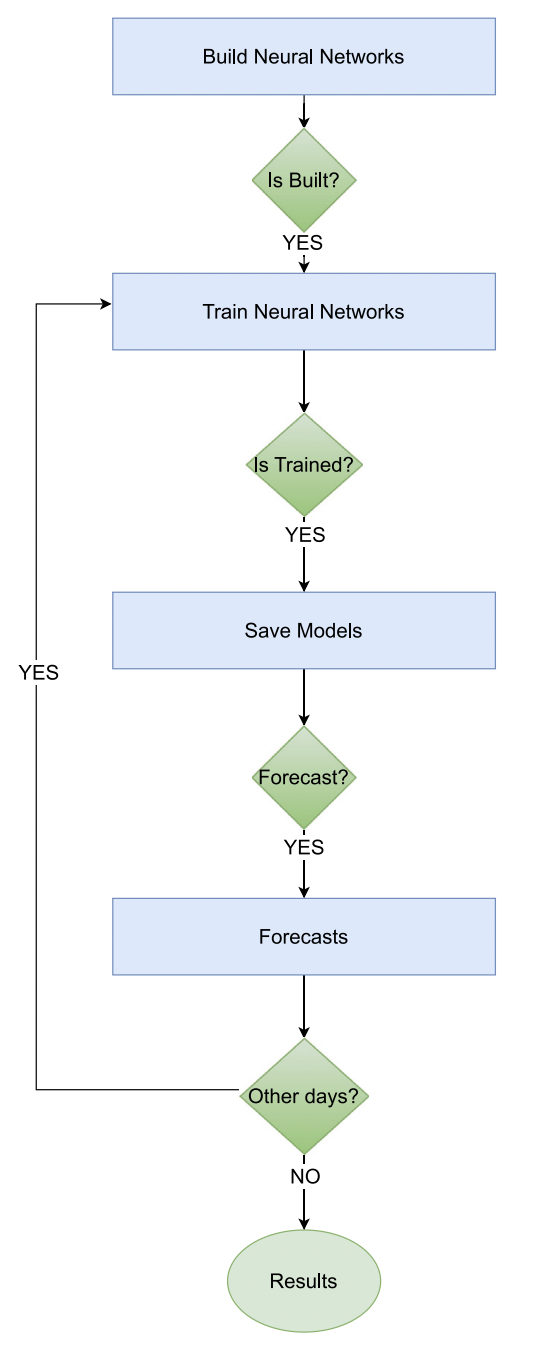

In [47]:
SAVE_DIR = "/content/drive/MyDrive/Muhammad Alvero/DS/Model"

def create_sequences(X, y, time_steps=2):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def heuristic_score(y_true, y_pred):
    """Heuristic Stocks Selection Algorithm"""
    return y_pred / (1 + np.abs(y_true - y_pred))

def run_advice_unit(all_splits, SAVE_DIR, K=5, time_window=2, epochs=3, batch_size=32):
    """
    Rolling prediction + re-train
    """
    models = {}
    for fname in os.listdir(SAVE_DIR):
        if fname.endswith(".keras"):
            stock = fname.replace(".keras", "")
            model_path = os.path.join(SAVE_DIR, fname)
            model = tf.keras.models.load_model(model_path, compile=False)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          loss='mse')
            models[stock] = model

    # Save Daily Advice
    advice_history = []

    # Take the first date on stocks
    first_csv = list(all_splits.keys())[0]
    dates = all_splits[first_csv]["test"]["Date"].values

    # Daily Rolling
    for day in range(time_window, len(dates)):
        day_preds = {}
        day_scores = {}

        for stock, model in models.items():
            csv_key = stock + ".csv"
            if csv_key not in all_splits:
                continue

            df_test = all_splits[csv_key]["test"]
            y_test_full = df_test["DR"].values
            if len(y_test_full) < time_window + 1 or day >= len(y_test_full):
                continue

            X_test_full = df_test.drop(columns=["Date", "DR"]).values
            X_input = X_test_full[day - time_window:day].reshape(1, time_window, -1)
            y_true = y_test_full[day]

            y_pred = model.predict(X_input, verbose=0)[0][0]
            score = heuristic_score(y_true, y_pred)

            day_preds[stock] = (y_true, y_pred)
            day_scores[stock] = score

        if not day_scores:
            continue

        # Top-K Stocks
        ranked = sorted(day_scores.items(), key=lambda x: x[1], reverse=True)
        top_k = ranked[:K]

        advice_history.append({
            "Date": dates[day],
            "Top_K": [s for s, _ in top_k],
            "Scores": [sc for _, sc in top_k],
            "Predicted_DR": [day_preds[s][1] for s, _ in top_k],
            "Actual_DR": [day_preds[s][0] for s, _ in top_k]
        })

        # Re train model
        for stock, model in models.items():
            csv_key = stock + ".csv"
            if csv_key not in all_splits:
                continue

            df_trainval = pd.concat([
                all_splits[csv_key]["train"],
                all_splits[csv_key]["val"],
                all_splits[csv_key]["test"].iloc[:day+1]
            ])

            X_train_full = df_trainval.drop(columns=["Date", "DR"]).values
            y_train_full = df_trainval["DR"].values
            X_train, y_train = create_sequences(X_train_full, y_train_full, time_steps=time_window)

            if len(X_train) > 0:
                model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    return pd.DataFrame(advice_history)


advice_df = run_advice_unit(all_splits, SAVE_DIR, K=5, time_window=2)

#### Daily Return

This final step is calculating the daily return from selecting best 5 stocks based on LSTM model prediction that already build. With comparing the actual daily return

In [48]:
def build_lookup_table(advice_df):
    rows = []
    for _, row in advice_df.iterrows():
        date = row["Date"]
        top_k = row["Top_K"]
        preds = row["Predicted_DR"]
        actuals = row["Actual_DR"]

        for i, stock in enumerate(top_k):
            rows.append({
                "Date": date,
                "Stock": stock,
                "Predicted_DR": preds[i],
                "Actual_DR": actuals[i],
                "Profit/Loss": actuals[i]
            })

        # Adding portfolio summary
        rows.append({
            "Date": date,
            "Stock": "PORTFOLIO_AVG",
            "Predicted_DR": np.mean(preds),
            "Actual_DR": np.mean(actuals),
            "Profit/Loss": np.mean(actuals)
        })

    return pd.DataFrame(rows)


In [54]:
# Lookup table
lookup_df = build_lookup_table(advice_df)

# Look 2 Months Daily Return Performance
lookup_df.head(20)

,Date,Stock,Predicted_DR,Actual_DR,Profit/Loss
0,2024-07-31,AMZN,0.978111,1.042957,1.042957
1,2024-07-31,FITB,0.337011,0.355538,0.355538
2,2024-07-31,BA,0.295744,0.379187,0.379187
3,2024-07-31,GE,0.417558,-0.392110,-0.392110
4,2024-07-31,FOX,0.592641,-1.033517,-1.033517
5,2024-07-31,PORTFOLIO_AVG,0.524213,0.070411,0.070411
6,2024-08-01,T,0.479412,0.828585,0.828585
7,2024-08-01,CHTR,0.792110,-1.094090,-1.094090
8,2024-08-01,GOOG,0.273639,0.273288,0.273288
9,2024-08-01,GE,0.577643,-0.585652,-0.585652


In [57]:
# Save to CSV in Google Drive
lookup_df.to_csv("/content/drive/MyDrive/Prediction & Recommendation.csv", index=False)

In [59]:
lookup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          396 non-null    datetime64[ns]
 1   Stock         396 non-null    object        
 2   Predicted_DR  396 non-null    float32       
 3   Actual_DR     396 non-null    float64       
 4   Profit/Loss   396 non-null    float64       
dtypes: datetime64[ns](1), float32(1), float64(2), object(1)
memory usage: 14.1+ KB


In [72]:
lookup_df_clean = lookup_df[lookup_df["Stock"] != "PORTFOLIO_AVG"].copy()

# Accumulation profit/loss per day
daily_summary = (
    lookup_df_clean.groupby("Date")
    .agg(
        Total_Profit_Loss=("Profit/Loss", "sum"),
        Stocks_Bought=("Stock", lambda x: list(x))
    )
    .reset_index()
)

daily_summary.head(25)

,Date,Total_Profit_Loss,Stocks_Bought
0,2024-07-31,0.352056,"[AMZN, FITB, BA, GE, FOX]"
1,2024-08-01,-3.335534,"[T, CHTR, GOOG, GE, AMZN]"
2,2024-08-02,1.777172,"[SCHW, AMZN, GOOG, FITB, ERIE]"
3,2024-08-05,4.068477,"[FANG, ABNB, GOOG, DRI, T]"
4,2024-08-06,5.803120,"[DXCM, ETN, CTRA, DOV, FDX]"
5,2024-08-07,-6.443702,"[XYZ, T, ETN, XOM, DXCM]"
6,2024-08-08,7.896956,"[CPAY, DXCM, ETN, ABNB, AMZN]"
7,2024-08-09,4.192663,"[ABNB, EW, ETN, APA, FDX]"
8,2024-08-12,4.497200,"[DXCM, EW, APA, ETN, AMZN]"
9,2024-08-13,6.096458,"[AMZN, EW, DOV, ABNB, APA]"


In [73]:
#  TOTAL RETURN in 2 Month
total_profit_loss = daily_summary["Total_Profit_Loss"].sum()

print("Total Profit/Loss:", total_profit_loss)

Total Profit/Loss: 340.62304252494863


This Portfolio profit is based on daily price calculation. Now for the final step is calculate the portofolio return. The calculation is:
- Total Profit/Loss : Total Initial Investment (Buy in Open price every day) x 100 Then Sell on Closing Price

In [75]:
base_path = "/content/drive/MyDrive/Muhammad Alvero/DS/SNP500"

# Getting Open price data in each stocks
open_prices = {}

for file in os.listdir(base_path):
    if file.endswith(".csv"):
        ticker = file.replace(".csv", "")
        df_stock = pd.read_csv(os.path.join(base_path, file))

        df_stock["Date"] = pd.to_datetime(df_stock["Date"])

        open_prices[ticker] = df_stock.set_index("Date")["Open"]

# Joint to predicted df (lookuup_df)
lookup_df_clean["Open"] = lookup_df_clean.apply(
    lambda row: open_prices[row["Stock"]].get(row["Date"], None), axis=1
)

# Total sum of open price
total_initial = lookup_df_clean["Open"].sum()

# Total profit/loss get
total_profit_loss = daily_summary["Total_Profit_Loss"].sum()

# Return percentage
portfolio_return_percent = (total_profit_loss / total_initial) * 100

print("Portfolio Return (%):", portfolio_return_percent)

Portfolio Return (%): 0.5494883387288229


The Portfolio get 54% return based on the performance of LSTM Forecasting and Heuristic Stock Selection Algorithm

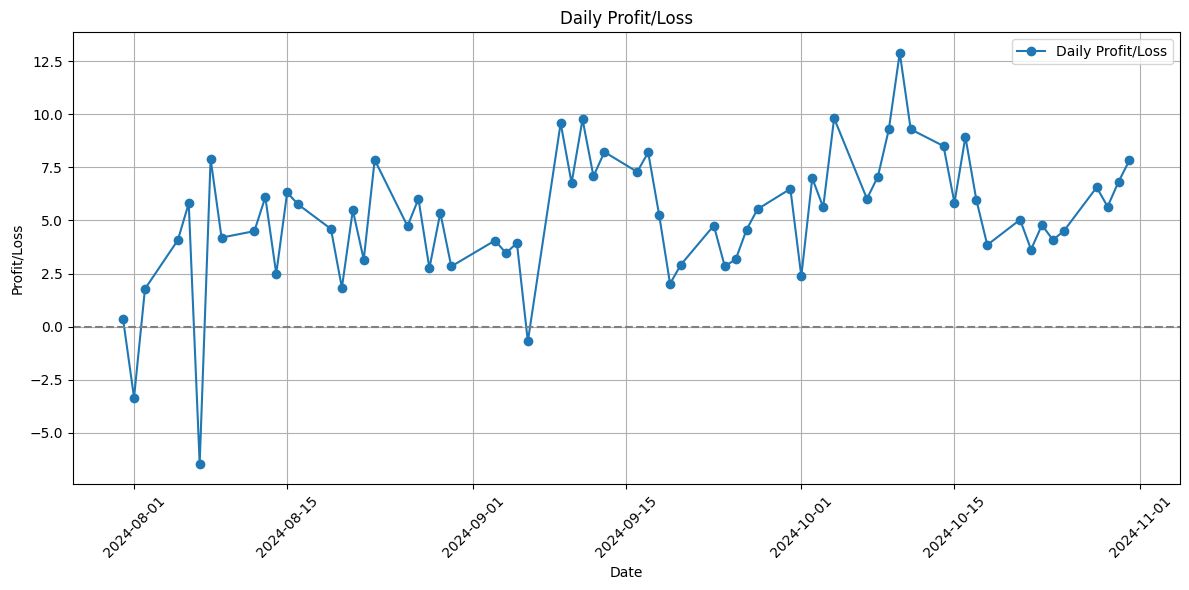

In [76]:
import matplotlib.pyplot as plt

# Cummulative Profit/Loss
if "Cumulative_PL" not in daily_summary.columns:
    daily_summary["Cumulative_PL"] = daily_summary["Total_Profit_Loss"].cumsum()

# Plot 1: Daily Profit/Loss
plt.figure(figsize=(12,6))
plt.plot(daily_summary["Date"], daily_summary["Total_Profit_Loss"], marker="o", linestyle="-", label="Daily Profit/Loss")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Daily Profit/Loss")
plt.xlabel("Date")
plt.ylabel("Profit/Loss")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

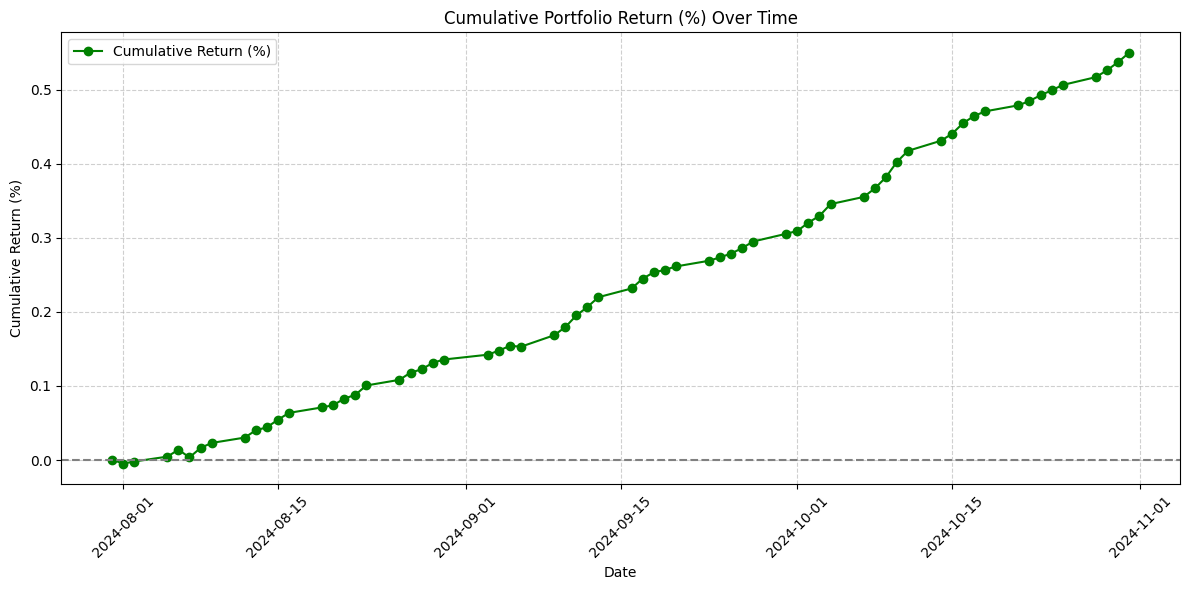

In [78]:
# Cumulative in %
daily_summary["Cumulative_Return_%"] = (daily_summary["Cumulative_PL"] / total_initial) * 100

# Plot 2: Cumulative Return (%)
plt.figure(figsize=(12,6))
plt.plot(daily_summary["Date"], daily_summary["Cumulative_Return_%"], marker="o", linestyle="-", color="green", label="Cumulative Return (%)")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Cumulative Portfolio Return (%) Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()